<a href="https://colab.research.google.com/github/Sanim27/Torch/blob/main/BasicNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bringing the data in

In [35]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/images.zip'
extraction_dir = '/content/'  # Extract to root content directory, it will maintain train/, test/, and val/ folders

# Unzip the file, preserving the folder structure
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f"Files extracted to: {extraction_dir}")


Files extracted to: /content/


# Loading the data

### The two way of interacting with data are datasets and dataloaders. Dataset is a python class that allows us to get the data we are supplying to the neural network. Dataloader is what feeds neural network with data from dataset.

Dataset class must contain __getitem__ and __len__

### BUILDING A TRAINING DATASET

Torchvision class contains the ImageFolder that does pretty much everything for us, providing our images are in correct structure where each directory is a label.

### For our cats and fish classification

In [64]:
import torchvision
from torchvision import transforms
train_data_path='./train/'
transforms=transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485,0.456,0.406],
            std=[0.229,0.224,0.225]
            )
    ]
)

train_data=torchvision.datasets.ImageFolder(root=train_data_path,transform=transforms)

In the code above, torchvision also allows us to perform a list of transforms before feeding the data into the neural network. The default transform is just transform.ToTensor() but we have done additional transforms above.

GPUs perform better if all data in the datasets are the same size. Hence all images are resized into (64,64) shape using transforms.Resize(64). The transforms.Normalize() is necessary as well as many multiplication are to be done in many layers of NN. To avoid exploding gradients. The above means and std ensure that the mean is 0 and std is 1. For imagenet dataset we must take the mean and std as above.

# For loading val and test datasets

In [65]:
val_path='./val/'
test_path='./test/'
val_data=torchvision.datasets.ImageFolder(root=val_path,transform=transforms)
test_data=torchvision.datasets.ImageFolder(root=test_path,transform=transforms)

### Finally building our dataloaders.

In [66]:
import torch

In [67]:
batch_size=64
train_data_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_data_loader=torch.utils.data.DataLoader(val_data,batch_size=batch_size,shuffle=False)
test_data_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

Batch Size tells how many data go into model before we train and update the weights.

# Finally the NEURAL NETWORK

In [68]:
import torch.nn as nn
import torch.nn.functional as F

In [69]:
class SimpleNet(nn.Module):
  def __init__(self):
    super(SimpleNet,self).__init__()
    self.fc1=nn.Linear(12288,84)
    self.fc2=nn.Linear(84,50)
    self.fc3=nn.Linear(50,2)

  def forward(self,x):
    x = x.view(-1, 12288)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)  # softmax thing is to be done later by CrossEntropy loss itself.
    return x

simplenet=SimpleNet()

### Optimizer

Adam, SGD, RmsProp

In [70]:
import torch.optim as optim
optimizer=optim.Adam(simplenet.parameters(),lr=0.001)

# TRAINING

In [71]:
# for epoch in range(epochs):
#   for batch in train_data_loader:
#     optimizer.zero_grad()    # It is to be noted that calculated gradients get accumulated. Hence this is needed to make the gradients 0 at the end of batch iteration.
#     input,target=batch
#     output=simplenet(input)
#     loss=loss_fn(output,target)
#     loss.backward()
#     optimizer.step()

### Making it work in the GPU

To utilize the GPU , we must move the input tensors and model itself to the GPU using to() method

In [72]:
if torch.cuda.is_available():
  print('cuda')
  device=torch.device('cuda')
else:
  device=torch.device('cpu')
  print('cpu')
simplenet.to(device)

cuda


SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

### PUTTING IT ALL TOGETHER

In [73]:
def train(model,optimizer,loss_fn,train_loader,val_loader,epochs=20,device='cpu'):
  for epoch in range(epochs):
    training_loss=0.0
    valid_loss=0.0
    model.train()
    for batch in train_loader:
      optimizer.zero_grad()
      inputs,targets=batch
      inputs=inputs.to(device)
      targets=targets.to(device)
      output=model(inputs)
      loss=loss_fn(output,targets)
      loss.backward()
      optimizer.step()
      training_loss+=loss.data.item()
    training_loss/=len(train_loader)

    model.eval()
    num_correct=0
    num_examples=0
    for batch in val_loader:
      inputs,targets=batch
      inputs=inputs.to(device)    # zero_grad() is not needed since model weights are not updated during validation.
      output=model(inputs)
      targets=targets.to(device)
      loss=loss_fn(output,targets)
      valid_loss+=loss.data.item()
      correct=torch.eq(torch.max(F.softmax(output),dim=1)[1],targets).view(-1)
      num_correct=torch.sum(correct).item()
      num_examples+=correct.shape[0]
    valid_loss/=len(val_loader)
    print('Epoch: {}, Training loss: {:.2f}, Validation loss: {:.2f}, accuracy: {:.2f}'.format(epoch,training_loss,valid_loss,num_correct/num_examples))

In [74]:
import os
from PIL import Image, UnidentifiedImageError

# Define the directories for cat and fish images
cat_directory = '/content/train/cat'
fish_directory = '/content/train/fish'

# Function to check images in a given directory
def check_images_in_directory(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):  # Check only JPG files
            file_path = os.path.join(directory, filename)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify the image
            except (IOError, UnidentifiedImageError):
                print(f"Corrupted image file: {file_path}")

# Check images in both directories
check_images_in_directory(cat_directory)
check_images_in_directory(fish_directory)


In [81]:
import os
from PIL import Image

def remove_corrupted_images(image_folder):
    """
    Removes corrupted images from the given folder and updates ImageFolder's samples.
    """
    corrupted_files = []
    # Get a list of all image files in the directory
    all_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]


    # Loop through each file in the directory
    for filename in all_files:
        file_path = os.path.join(image_folder, filename)

        # Check if the file is an image
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            try:
                # Try to open the image file
                img = Image.open(file_path)
                img.verify()  # Verify the image
                # If the verification step raises an error, it means that the image is corrupted and therefore will be removed.
            except (IOError, SyntaxError) as e:
                # If there's an error, append to the list and remove the file
                corrupted_files.append(file_path)
                os.remove(file_path)
                print(f"Corrupted image file removed: {file_path}")

    # Return the list of corrupted files for reference
    return corrupted_files

# ... (Rest of the code remains the same)


# After removing corrupted images, update the ImageFolder's samples:
# Assuming 'train_data_loader' and 'val_data_loader' are instances of DataLoader with ImageFolder datasets
# Update train dataset
train_data_loader.dataset.samples = [
    (path, cls) for path, cls in train_data_loader.dataset.samples
    if os.path.exists(path)  # Keep only existing files
]
train_data_loader.dataset.imgs = train_data_loader.dataset.samples # Update imgs to reflect changes in samples, this is important for ImageFolder

# Update validation dataset
val_data_loader.dataset.samples = [
    (path, cls) for path, cls in val_data_loader.dataset.samples
    if os.path.exists(path)  # Keep only existing files
]
val_data_loader.dataset.imgs = val_data_loader.dataset.samples # Update imgs to reflect changes in samples, this is important for ImageFolder

In [82]:
train(simplenet,optimizer,torch.nn.CrossEntropyLoss(),train_data_loader,val_data_loader,device=device)

<ipython-input-73-3d720ac2a30e>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct=torch.eq(torch.max(F.softmax(output),dim=1)[1],targets).view(-1)


Epoch: 0, Training loss: 0.23, Validation loss: 1.08, accuracy: 0.28
Epoch: 1, Training loss: 0.19, Validation loss: 0.72, accuracy: 0.27
Epoch: 2, Training loss: 0.14, Validation loss: 0.70, accuracy: 0.33
Epoch: 3, Training loss: 0.09, Validation loss: 0.99, accuracy: 0.28
Epoch: 4, Training loss: 0.06, Validation loss: 1.10, accuracy: 0.28
Epoch: 5, Training loss: 0.06, Validation loss: 1.18, accuracy: 0.28
Epoch: 6, Training loss: 0.05, Validation loss: 1.11, accuracy: 0.29
Epoch: 7, Training loss: 0.03, Validation loss: 0.98, accuracy: 0.31
Epoch: 8, Training loss: 0.02, Validation loss: 1.16, accuracy: 0.29
Epoch: 9, Training loss: 0.01, Validation loss: 1.25, accuracy: 0.27
Epoch: 10, Training loss: 0.01, Validation loss: 1.24, accuracy: 0.28
Epoch: 11, Training loss: 0.01, Validation loss: 1.22, accuracy: 0.29
Epoch: 12, Training loss: 0.00, Validation loss: 1.28, accuracy: 0.30
Epoch: 13, Training loss: 0.00, Validation loss: 1.22, accuracy: 0.29
Epoch: 14, Training loss: 0.00

MAKING PREDICTIONS. BUT I GUESS THE MODEL HAS OVERFITTED.

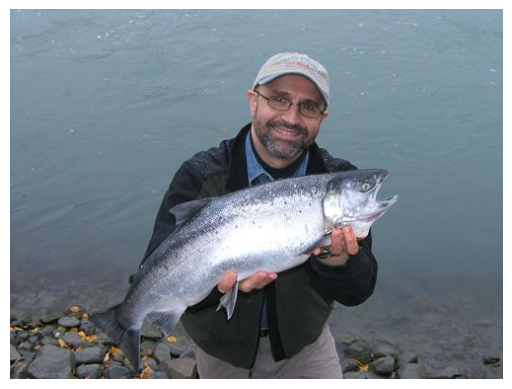

fish


In [94]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

labels = ['cat', 'fish']
img_path = '/content/test/fish/SteveSilver.jpg'
img = Image.open(img_path)


plt.imshow(img)
plt.axis('off')
plt.show()


img_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = img_transforms(img)
img = img.unsqueeze(0)
img = img.to(device)
with torch.no_grad():
    prediction = simplenet(img)
    prediction = prediction.argmax()

print(labels[prediction.item()])

### MODEL SAVING

In [95]:
# Save the model weights
torch.save(simplenet.state_dict(), 'simplenet_weights.pth')